## Objective
<br> 

> Text Recognition은 영상 내 단어의 배열을 알아내는 Task입니다. 아래의 단계에서 2번째에 해당하는 Task입니다.

![](https://cdn-images-1.medium.com/max/1600/0*QmbvekTewz63Y_8X.)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

import sys
import shutil
import os

import tensorflow as tf
from functools import partial

from tensorflow.examples.tutorials.mnist import input_data

### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [2]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))

    display(HTML(iframe))

In [3]:
class SerializationDataset:
    """
    generate data for Serialization

    이 class는 단순히 숫자를 나열하는 것

    :param data_type : Select one, (train, test, validation)
    :param digit : the length of number (몇개의 숫자를 serialize할 것인지 결정)
    :param bg_noise : the background noise of image, bg_noise = (gaussian mean, gaussian stddev)
    :param pad_range : the padding length between two number (두 숫자 간 거리, 값의 범위로 주어 랜덤하게 결정)
    """

    def __init__(self, data_type="train",
                 digit=5, bg_noise=(0, 0.2), pad_range=(3, 10)):
        """
        generate data for Serialization

        :param data_type: Select one, (train, test, validation)
        :param digit : the length of number
          if digit is integer, the length of number is always same value.
          if digit is tuple(low_value, high_value), the length of number will be determined within the range
        :param bg_noise : the background noise of image, bg_noise = (gaussian mean, gaussian stddev)
        :param pad_range : the padding length between two number (두 숫자 간 거리, 값의 범위로 주어 랜덤하게 결정)
        """
        mnist = input_data.read_data_sets("mnist_data/")
        if data_type == "train":
            dataset = mnist.train
        elif data_type == 'validation':
            dataset = mnist.validation
        elif data_type == 'test':
            dataset = mnist.test
        
        self.images = dataset.images.reshape(-1,28,28)
        self.labels = dataset.labels
        
        if isinstance(digit, int):
            self.digit_range = (digit, digit + 1)
        else:
            self.digit_range = digit
        self.num_data = len(self.labels) // (self.digit_range[1] - 1)
        self.index_list = np.arange(len(self.labels))

        self.bg_noise = bg_noise
        self.pad_range = pad_range

        self.max_length = int((15 + pad_range[1]) * self.digit_range[1])

    def __len__(self):
        return self.num_data

    def __getitem__(self, index):
        if isinstance(index, int):
            num_digit = np.random.randint(*self.digit_range)
            start_index = (self.digit_range[1] - 1) * index
            digits = self.index_list[start_index:start_index + num_digit]

            digit_images = self.images[digits]
            digit_labels = self.labels[digits]
            series_image = self._serialize_random(digit_images)

            return series_image, digit_labels

        else:
            batch_images, batch_labels = [], []
            indexes = np.arange(self.num_data)[index]
            for _index in indexes:
                num_digit = np.random.randint(*self.digit_range)
                start_index = (self.digit_range[1] - 1) * _index
                digits = self.index_list[start_index:start_index + num_digit]

                digit_images = self.images[digits]
                digit_labels = self.labels[digits]
                series_image = self._serialize_random(digit_images)
                batch_images.append(series_image)
                batch_labels.append(digit_labels)

            return np.stack(batch_images), batch_labels

    def shuffle(self):
        indexes = np.arange(len(self.images))
        np.random.shuffle(indexes)

        self.images = self.images[indexes]
        self.labels = self.labels[indexes]

    def _serialize_random(self, images):
        """
        복수의 이미지를 직렬로 붙임

        :param images:
        :return:
        """
        pad_height = images.shape[1]
        pad_width = np.random.randint(*self.pad_range)

        serialized_image = np.zeros([pad_height, pad_width])
        for image in images:
            serialized_image = self._place_random(image, serialized_image)

        full_image = np.random.normal(*self.bg_noise,
                                      size=(pad_height, self.max_length))

        if serialized_image.shape[1] < self.max_length:
            series_length = serialized_image.shape[1]
            full_image[:, :serialized_image.shape[1]] += serialized_image
        else:
            series_length = full_image.shape[1]
            full_image += serialized_image[:, :full_image.shape[1]]

        full_image = np.clip(full_image, 0., 1.)
        return full_image

    def _place_random(self, image, serialized_image):
        """
        가운데 정렬된 이미지를 떼어서 재정렬함

        :param image:
        :param serialized_image:
        :return:
        """
        x_min, x_max, _, _ = self.crop_fit_position(image)
        cropped = image[:, x_min:x_max]

        pad_height = cropped.shape[0]
        pad_width = np.random.randint(*self.pad_range)
        pad = np.zeros([pad_height, pad_width])

        serialized_image = np.concatenate(
            [serialized_image, cropped, pad], axis=1)
        return serialized_image


    def crop_fit_position(self, image):
        """
        get the coordinates to fit object in image

        :param image:
        :return:
        """
        positions = np.argwhere(
            image >= 0.1)  # set the threshold to 0.1 for reducing the noise

        y_min, x_min = positions.min(axis=0)
        y_max, x_max = positions.max(axis=0)

        return np.array([x_min, x_max, y_min, y_max])

위에서 구성한 데이터셋은 아래와 같이 이용할 수 있습니다.

In [4]:
train_dataset = SerializationDataset(data_type='train',digit=(3,7))
validation_dataset = SerializationDataset(data_type='validation',digit=(3,7))
test_dataset = SerializationDataset(data_type='test',digit=(5,10))

W0629 08:11:25.259781 4554659264 deprecation.py:323] From <ipython-input-3-e00ad07f6a23>:25: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0629 08:11:25.261327 4554659264 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0629 08:11:25.262812 4554659264 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instr

Extracting mnist_data/train-images-idx3-ubyte.gz


W0629 08:11:25.510894 4554659264 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0629 08:11:25.557663 4554659264 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz
Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


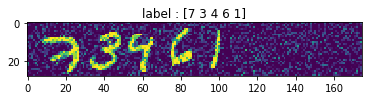

In [5]:
image, label = train_dataset[0]

plt.title(f"label : {label}")
plt.imshow(image)
plt.show()

해당 데이터는 글자 이미지(image)와 글자 정보(label)로 구성되어 있습니다.


이번 데이터 셋은 데이터마다 가변적인 길이를 갖습니다. 위에서 구현한 `SerializationDataset`의 매개변수인 `digit`은 몇개의 단어 배열을 구성할 지를 결정합니다.

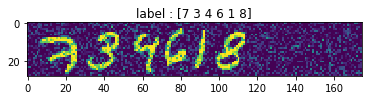

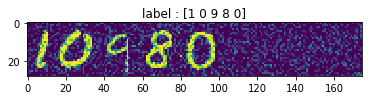

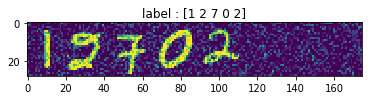

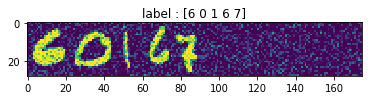

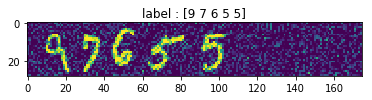

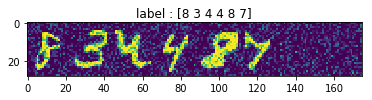

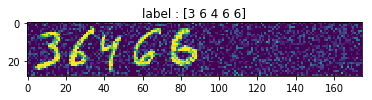

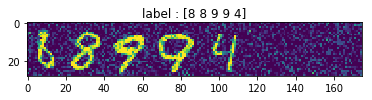

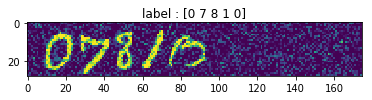

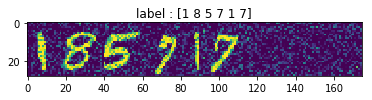

In [6]:
images, labels = train_dataset[:10]

for image, label in zip(images, labels):
    plt.title(f"label : {label}")
    plt.imshow(image)
    plt.show()

## Generator 구성하기

학습을 할 때에는 배치단위로 학습하게 됩니다.<br> 
Label의 경우에는 길이가 가변적인 형태를 띕니다. 그렇다면, 어떻게 구성해야 할까요? 해법은 바로,Blank라는 라벨을 만들어 따로 채워주는데에 있습니다.

In [7]:
from tensorflow.keras.utils import Sequence

In [8]:
class DataGenerator(Sequence):
    "Generates Text Recognition Dataset for Keras"

    def __init__(self, dataset, batch_size=32, shuffle=True):
        "Initialization"
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_classes = self.dataset.labels.max()  # With Blank
        self.max_length = self.dataset.digit_range[-1]
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return len(self.dataset) // self.batch_size

    def __getitem__(self, index):
        "Generator one batch of dataset"
        images, labels = self.dataset[self.batch_size * index:
                                      self.batch_size * (index + 1)]
        # Add Channel axis (batch, width, height) -> (batch, width, height, 1)
        batch_images = images[..., np.newaxis]

        # label sequence
        batch_labels = np.ones([self.batch_size, self.max_length+1], np.int32)
        batch_labels *= self.num_classes + 1  # BLANK Token value
        for idx, label in enumerate(labels):
            batch_labels[idx, :len(label)] = label

        return batch_images, batch_labels

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        if self.shuffle:
            self.dataset.shuffle()

In [9]:
# Keras의 모델에 넣을 수 있는 형태로, 데이터셋을 Transform하는 generator
train_generator = DataGenerator(train_dataset,batch_size=3)
validation_generator = DataGenerator(validation_dataset)
test_generator = DataGenerator(test_dataset)

/Users/ksj/anaconda3/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


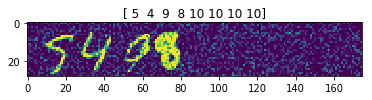

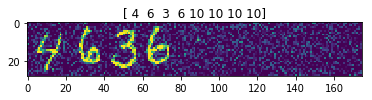

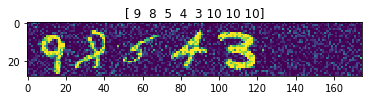

In [10]:
images, labels = train_generator[0]
for image, label in zip(images, labels):
    plt.title(label)
    plt.imshow(image[:,:,0])
    plt.show()

여기서 패딩은 10이라는 라벨로 분류되었습니다.

# CRNN Model 구성하기

---
---

구현할 모델은 CRNN(Convolution Recurrent Neural Network)입니다.

![](http://blog.skby.net/blog/wp-content/uploads/2019/01/1-51.png)

reference : [An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](https://arxiv.org/abs/1507.05717)

##  1. Convolutional Layers 구성하기
---

이 모델의 Feature Extractor는 Maxpooling과 Convolution Layer가 교차되는 형식으로 구성되었습니다.<br>
특이 사항으로는 width 방향으로 동적 길이를 가집니다. 코드 작업의 편리함을 위해, 우리는 이미지를 한번 전치 후 사용합니다. <br>

논문이 다루고 있는 문제 보다 simple하므로, Convolution Layer의 크기를 줄이도록 하겠습니다.

In [11]:
heights = 28
num_classes = 10

num_features = 16 # Convolution Filter의 갯수

graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=(None,heights,None,1),name='image')
    is_train = tf.placeholder_with_default(False,None,name='is_train')
    
    with tf.variable_scope("conv_layers"):
        conv_layer = partial(tf.layers.Conv2D,
                             kernel_size=(3,3),
                             padding='same',
                             activation=tf.nn.relu)
        maxpool_layer = partial(tf.layers.MaxPooling2D,
                                pool_size=(2,2),
                                strides=(2,2),
                                padding='same')
        BN = tf.layers.BatchNormalization
        
        transposed_x = tf.transpose(x,[0,2,1,3])
        conv1 = conv_layer(num_features,name='conv1')(transposed_x)
        max1 = maxpool_layer(name='maxpool1')(conv1)
        conv2 = conv_layer(num_features*2,name='conv2')(max1)    
        max2 = maxpool_layer(name='maxpool2')(conv2)
        conv3 = conv_layer(num_features*4,name='conv3')(max2)
        conv4 = conv_layer(num_features*4,name='conv4')(conv3)
        max3 = maxpool_layer(name='maxpool3')(conv4)
        
        conv5 = conv_layer(num_features*8,name='conv5')(max3)
        bn1 = BN(name='bn1')(conv5,training=is_train)
        conv6 = conv_layer(num_features*8,name='conv6')(bn1)
        bn2 = BN(name='bn2')(conv6,training=is_train)
        max4 = maxpool_layer(pool_size=(1,2),
                             strides=(1,2),
                             name='maxpool4')(bn2)
        
        conv7 = conv_layer(num_features*8,kernel_size=(2,2),
                           name='conv7')(max4)
    conv7 = tf.identity(conv7,name='image_features')

W0629 08:11:29.312655 4554659264 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
show_graph(graph)

## 2. Convolution layer to RNN Layer로 맵핑하는 부분 구성
---

Convolution Layer을 통과하고 나면<br>
Shape : (batch_size, feature_map_width, feature_map_height, num_features)로 구성됩니다.<br>

현재 글자는 X축 방향으로 진행되고 있기 때문에, x축 방향이 time step 방향이 됩니다.<br>
RNN의 Input으로 넣기 위해 <br>
Shape : (batch_size, feature_map_width, feature_map_height * num_features)으로<br>
바꾸어주어야 합니다.

In [13]:
with graph.as_default():
    with tf.variable_scope('map-to-sequence'):
        shape = tf.shape(conv7)
        height, n_channel = conv7.shape.as_list()[-2:]
        feature_seqs = tf.reshape(conv7,shape=[shape[0],shape[1],height*n_channel])
    feature_seqs = tf.identity(feature_seqs, name='feature_sequences')

In [14]:
show_graph(graph)

## 3. stacked Bidirectional LSTM 구성
---

총 2층의 Bidrectional LSTM Layer가 구성됩니다.

In [15]:
num_depth = 2
num_features = 128

with graph.as_default():
    with tf.variable_scope('recurrent_layers'):
        outputs = feature_seqs
        for i in range(num_depth):
            with tf.variable_scope('bidirectional_{}'.format(i+1)):
                bidirectional = tf.keras.layers.Bidirectional
                LSTM = tf.keras.layers.LSTM
                outputs = bidirectional(
                    LSTM(num_features,
                         return_sequences=True))(outputs)
    rnn_seqs = tf.identity(outputs, name='rnn_sequences')

W0629 08:11:29.912899 4554659264 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0629 08:11:29.915082 4554659264 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0629 08:11:29.916613 4554659264 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) w

In [16]:
show_graph(graph)

## 4. Transcription Layer 구성
---

학습데이터에 클래스 라벨의 순서만 존재하고, 각 클래스의 위치가 정확히 어디인지 모르는 경우,<br>
CTC(Connectionist Temporal Classification) Loss를 이용합니다.

구체적인 설명은 [Youtube 강좌](https://www.youtube.com/watch?v=GxtMbmv169o)를 들어보면 좋습니다.

In [17]:
with graph.as_default():
    targets = tf.placeholder(tf.int32,shape=(None,None),name='targets')
    with tf.variable_scope('transcription'):
        with tf.variable_scope('sequence_length'):
            shape = tf.shape(rnn_seqs)
            batch_size, max_len, _ = tf.split(shape, 3, axis=0)
            seq_len = tf.ones(batch_size, tf.int32) * max_len        
        
        # Calculate Loss by CTC
        logits = tf.layers.Dense(num_classes + 1, name='logits')(rnn_seqs)
        logits_tp = tf.transpose(logits,[1,0,2])
        
        with tf.variable_scope('dense-to-sparse'):
            # CTC Loss를 계산할 때는 Tensor가 아닌 SparseTensor를 이용해야해서
            # 형변환을 거쳐주는 작업
            indices = tf.where(tf.not_equal(targets, num_classes))
            values = tf.gather_nd(targets, indices)
            shape = tf.cast(tf.shape(targets),dtype=tf.int64)
            sparse_targets = tf.SparseTensor(indices,values,shape)
        
        with tf.variable_scope('losses'):
            loss = tf.nn.ctc_loss(sparse_targets, logits_tp, seq_len)
        
        with tf.variable_scope('decoder'):
            # Calculate the best path by Greedy Algorithm        
            decoded, b = tf.nn.ctc_greedy_decoder(logits_tp,
                                                  sequence_length=seq_len)
            pred = tf.sparse.to_dense(decoded[0],default_value=-1) # Result -> 우리의 예측값
    
    loss = tf.reduce_mean(loss, name='ctc_loss')
    pred = tf.identity(pred, name='prediction')

W0629 08:11:31.134650 4554659264 deprecation.py:323] From <ipython-input-17-7fb4eed9f846>:16: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
show_graph(graph)

## 5. Metric 구성
---

두 문자열의 유사도를 측정하는 방식으로는 Levenshtein distance, 별칭 `edit distance`가 있습니다.<br>

값은 0에 가까울수록 두 문자열의 유사도가 완전 일치에 가깝고,1에 가까울수록 완전 불일치에 가깝습니다. 즉 낮을수록 더 정확한 모델입니다.

In [19]:
with graph.as_default():
    with tf.variable_scope("metric"):
        label_error_rate = tf.reduce_mean(
            tf.edit_distance(tf.cast(decoded[0], tf.int32),
                             sparse_targets),
            name='label_error_rate')

In [20]:
show_graph(graph)

## 6. Optimizer 구성
---

BatchNormalization을 CNN에 넣었기 때문에, 배치 단위 별 EMA(Mean & Variance)를 위해<br>
update_ops를 호출해야 합니다. control_dependencies에 추가해주면, train_op 호출시 update_ops도 자동으로 호출되게 됩니다.

In [21]:
with graph.as_default():
    lr = tf.placeholder_with_default(0.01,None,name='learning_rate')
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = (tf.train
                    .AdamOptimizer(learning_rate=lr)
                    .minimize(loss))

In [22]:
show_graph(graph)

# CRNN Model 학습 및 평가하기

---
---


## 1. 모델 학습하기
---

2 epoch만 학습시켜 보도록 하겠습니다.

In [23]:
try:
    from tqdm import tqdm
except ImportError:
    !pip install tqdm
    from tqdm import tqdm

In [24]:
train_generator = DataGenerator(train_dataset,batch_size=16)

In [25]:
num_epoch = 2
learning_rate = 0.001

with graph.as_default():
    sess = tf.Session(graph=graph)
    sess.run([tf.global_variables_initializer(),
          tf.local_variables_initializer()])
    
    for i in range(num_epoch):
        for idx in tqdm(range(len(train_generator))):
            batch_images, batch_labels = train_generator[idx]
            sess.run(train_op, feed_dict={
                    x : batch_images,
                    targets : batch_labels,
                    lr : learning_rate,
                    is_train : True})
        train_generator.on_epoch_end()

100%|██████████| 572/572 [01:54<00:00,  5.00it/s]


## 2. 모델 결과 확인하기
---

테스트 데이터셋을 통해 모델을 구동시켜 보도록 하겠습니다.

In [ ]:
test_images, test_labels = test_generator[0]

outputs = sess.run(decoded, feed_dict={x:test_images[:5]})

for output, image in zip(outputs, test_images):
    plt.title(output)
    plt.imshow(image[:,:,0])
    plt.show()

## Reference

1. [CTC Loss에 대한 개괄적 설명](https://m.blog.naver.com/PostView.nhn?blogId=sogangori&logNo=221183469708&proxyReferer=https%3A%2F%2Fwww.google.com%2F)
2. [Levenshtein(edit) distance를 이용한 한국어 단어의 형태적 유사성](https://lovit.github.io/nlp/2018/08/28/levenshtein_hangle/)